In [2]:
import os
import re
import time
import math
import pickle
import openai
import textstat
import webbrowser
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from scipy.stats import kruskal, shapiro, mannwhitneyu, kendalltau, chi2_contingency, f_oneway

In [3]:
path_dataset = '../../Dataset'
path_result = '../../Result'

path_rq12 = os.path.join(path_result, 'RQ12')
path_rq4 = os.path.join(path_result, 'RQ4')

openai.api_key = os.getenv('OPENAI_API_KEY', 'xxxxxx')

pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

color_map = {
    'Problem': 'tomato',
    'Knowledge': 'dodgerblue',
}

zoom_mapping = {
    'problem': 5,
    'knowledge': 5,
}

In [10]:
def input_solution_summary(link):
    webbrowser.open(link)
    user_input = input("Please input a summary for the opened link: ")
    return user_input

def find_duplicates(in_list):  
    duplicates = []
    unique = set(in_list)
    for each in unique:
        count = in_list.count(each)
        if count > 1:
            duplicates.append(each)
    return duplicates

def reshape_dataframe(df: pd.DataFrame, num_new_columns: int) -> pd.DataFrame:
    # Create a new index for reshaping
    df['new_index'] = df.index // num_new_columns

    # Create new column names
    df['col'] = df.index % num_new_columns

    # Pivot the dataframe
    wide_df = df.pivot(index='new_index', columns='col')

    # Sort column levels to ensure they are ordered as 'index', 'name' across each group
    sorted_columns = sorted(wide_df.columns, key=lambda x: (x[1], x[0]))
    wide_df = wide_df[sorted_columns]

    # Flatten the MultiIndex to get the desired format
    wide_df.columns = [f'{col[0]}_{col[1] + 1}' for col in wide_df.columns]
    wide_df = wide_df.reset_index(drop=True)

    return wide_df

In [30]:
# file_new = 'macro-topics'
# file_old = 'labels'

# df_new = pd.read_json(os.path.join(path_rq12, f'{file_new}.json'))
# df_new = df_new[df_new['Challenge_resolved_time'].notna()]
# df_old = pd.read_json(os.path.join(path_rq4, f'{file_old}.json'))

# df_git = df_old[df_old['Platform'].str.contains('Git')]
# df_stack = df_old[df_old['Platform'].str.contains('Stack')]
# df_tool = df_old[df_old['Platform'].str.contains('Tool')]

# for index, row in df_new.iterrows():
#     if 'Git' in row['Platform']:
#         for i2, r2 in df_git.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary'] = r2['Solution_summary']
#                 break
#     elif 'Stack' in row['Platform']:
#         for i2, r2 in df_stack.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary'] = r2['Solution_summary']
#                 break
#     else:
#         for i2, r2 in df_tool.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary'] = r2['Solution_summary']
#                 break

# df_new.to_json(os.path.join(path_rq4, f'{file_old}.json'), indent=4, orient='records')

In [32]:
# file_new = 'labels'
# file_old = 'topics'

# df_new = pd.read_json(os.path.join(path_rq4, f'{file_new}.json'))
# df_new = df_new[df_new['Challenge_resolved_time'].notna()]
# df_old = pd.read_json(os.path.join(path_rq4, f'{file_old}.json'))

# df_git = df_old[df_old['Platform'].str.contains('Git')]
# df_stack = df_old[df_old['Platform'].str.contains('Stack')]
# df_tool = df_old[df_old['Platform'].str.contains('Tool')]

# for index, row in df_new.iterrows():
#     if 'Git' in row['Platform']:
#         for i2, r2 in df_git.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary_topic'] = r2['Solution_summary_topic']
#                 break
#     elif 'Stack' in row['Platform']:
#         for i2, r2 in df_stack.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary_topic'] = r2['Solution_summary_topic']
#                 break
#     else:
#         for i2, r2 in df_tool.iterrows():
#             if row['Challenge_link'] == r2['Challenge_link']:
#                 df_new.at[index, 'Solution_summary_topic'] = r2['Solution_summary_topic']
#                 break

# df_new.to_json(os.path.join(path_rq4, f'{file_old}.json'), indent=4, orient='records')

In [ ]:
# df_new = pd.read_json(os.path.join(path_rq12, 'macro-topics.json'))
# df_new = df_new[df_new['Challenge_closed_time'].notna()]
# df_old = pd.read_json(os.path.join(path_rq4, 'labels.json'))

# df_merged = pd.concat([df_new, df_old, df_old], ignore_index=True)
# df_merged = df_merged.drop_duplicates(subset=['Challenge_link'], keep=False)

# df_merged.to_json(os.path.join(path_rq4, 'merged.json'), indent=4, orient='records')

In [15]:
df = pd.read_json(os.path.join(path_rq12, 'macro-topics.json'))
df = df[df['Challenge_closed_time'].notna()]

for index, row in df.iterrows():
    df.at[index, 'Solution_summary'] = input_solution_summary(row['Challenge_link'])
    if index % 50 == 49:
        df.to_json(os.path.join(path_rq4, 'labels.json'), indent=4, orient='records')

df.to_json(os.path.join(path_rq4, 'labels.json'), indent=4, orient='records')
len(df)

4687

In [4]:
df = pd.read_json(os.path.join(path_rq4, 'labels.json'))
df['Platform'] = df['Platform'].apply(lambda x: f'{x} forums' if x == 'Tool-specific' else x)

df_non = df[df['Solution_summary'] == 'non-issue']
issue_non = df_non['Platform'].value_counts()

df_intermittent = df[df['Solution_summary'] == 'intermittent issue']
issue_intermittent = df_intermittent['Platform'].value_counts()

df_non_solution = df[df['Solution_summary'] == 'na']
issue_non_solution = df_non_solution['Platform'].value_counts()

df_standard = pd.concat([df, df_non, df_intermittent, df_non_solution])
df_standard = df_standard.drop_duplicates(subset=['Challenge_link'], keep=False, ignore_index=True)
issue_standard = df_standard['Platform'].value_counts()

result = pd.concat([issue_standard, issue_non, issue_intermittent, issue_non_solution], axis=1, keys=['Post number (standard)', 'Post number (non)', 'Post number (intermittent)', 'Post number (non-solution)'])
result = result.fillna(0).astype(int)
print(result.to_latex(index=False, escape=True))

\begin{tabular}{lrrrr}
\toprule
 & Post number (standard) & Post number (non) & Post number (intermittent) & Post number (non-solution) \\
Platform &  &  &  &  \\
\midrule
Stack Overflow & 2187 & 2 & 4 & 5 \\
GitHub Issues & 1432 & 6 & 15 & 159 \\
Tool-specific forums & 849 & 1 & 1 & 8 \\
GitHub Discussions & 17 & 0 & 0 & 0 \\
GitLab Issues & 1 & 0 & 0 & 0 \\
\bottomrule
\end{tabular}



In [ ]:
# prompt_topic = '''You will be given a set of topics refering to specific empirical software engineering resolution. Please summarize each topic in a phrase and attach one sentence description in the MLOps context. Also, you must guarantee that those phrases are not duplicate with one another.###\n'''

# with open(os.path.join(path_rq4, 'Topic terms.pickle'), 'rb') as handle:
#     topic_terms = pickle.load(handle)

#     topic_term_list = []
#     for index, topic in enumerate(topic_terms):
#         terms = ', '.join([term[0] for term in topic])
#         topic_term = f'Solution {index}: {terms}'
#         topic_term_list.append(topic_term)

#     prompt = prompt_topic + '\n'.join(topic_term_list) + '\n###\n'
#     completion = openai.ChatCompletion.create(
#         model='gpt-4',
#         messages=[{'role': 'user', 'content': prompt}],
#         temperature=0,
#         max_tokens=4000,
#         top_p=1,
#         frequency_penalty=0,
#         presence_penalty=0,
#         timeout=300,
#         stream=False)

#     topics = completion.choices[0].message.content
#     print(topics)

In [6]:
topics = '''Topic 0: Package Upgrade -  Involves updating software packages, APIs, or frameworks to their latest versions to improve MLOps performance and security. 
Topic 1: Recommendation -  Suggests the use of specific SDKs, APIs, databases, platforms, runtimes, versions, tasks, data or pipelines for data serialization, conversion, and modeling. 
Topic 2: Distributed Training -  Refers to the implementation and configuration of parallel or continuous training for efficient model development. 
Topic 3: Permission -  Involves creating, assigning, or modifying access permissions to ensure secure and controlled access to resources. 
Topic 4: Package Installation -  Refers to the process of downloading and installing software packages necessary for MLOps tasks. 
Topic 5: Logging Function -  Involves setting up logging systems or functions for tracking and debugging purposes. 
Topic 6: Package Version -  Involves changing, specifying, or updating software package versions to ensure compatibility and stability. 
Topic 7: Patch and Fix -  Refers to the process of deploying patches or fixes to resolve problems and improve system performance. 
Topic 8: Network Configuration -  Involves configuring or changing network settings to optimize data flow and system performance. 
Topic 9: Model Creation -  Refers to the process of creating or using custom machine learning models in MLOps. 
Topic 10: Run Configuration -  Involves specifying or changing run settings to control how tasks are executed. 
Topic 11: Argument -  Involves adding, modifying, or using arguments or parameters to control task behavior. 
Topic 12: Code Modification -  Refers to the process of changing or rearranging code to improve system functionality or performance. 
Topic 13: Job Processing -  Involves executing or implementing jobs, possibly in parallel or scheduled manner, to perform specific tasks. 
Topic 14: SDK Upgrade -  Involves updating or changing the Software Development Kit (SDK) used to access the latest features or improvements. 
Topic 15: Storage Mounting -  Refers to the process of setting up and using local, network, or remote storage for data handling. 
Topic 16: Credential Update -  Involves changing or updating authentication credentials to ensure secure access to resources. 
Topic 17: Pipeline Configuration -  Involves creating, updating, or modifying pipelines for efficient data processing and model training. 
Topic 18: Resource Limit Adjustment -  Refers to reducing batch sizes, request limits, or resource usage to optimize system performance. 
Topic 19: Directory -  Involves setting or specifying filepaths and directories for organized data storage and access. 
Topic 20: Container Customization -  Refers to creating, using, or modifying custom containers for isolated and reproducible environments. 
Topic 21: Docker -  Involves changing, customizing, or deploying Docker images for containerized application deployment. 
Topic 22: Package Addition -  Involves adding new software packages or dependencies to extend the functionality of the system. 
Topic 23: Endpoint Invocation -  Refers to the process of creating or invoking endpoints for API communication. 
Topic 24: Environment Creation -  Involves setting up or customizing environments for reproducible and controlled task execution. 
Topic 25: Pipeline Deployment -  Refers to the process of creating or implementing deployment pipelines for efficient model deployment. 
Topic 26: Wait Time -  Involves adding or adjusting wait times or timeouts to control the execution flow of tasks. 
Topic 27: Command Line Usage -  Refers to using terminal, shell, or command line interfaces for direct system interaction. 
Topic 28: File Deletion -  Involves deleting files or folders to manage storage space and data organization. 
Topic 29: Service Provisioning -  Refers to creating or using services, possibly with authentication, for specific functionalities. 
Topic 30: Column Manipulation -  Involves adding, transforming, or deleting columns for data processing and analysis. 
Topic 31: Model Registration -  Refers to the process of registering or saving machine learning models for future use. 
Topic 32: Feature Filtering -  Involves using filtering or hashing techniques to select or generate relevant features for model training. 
Topic 33: Environment Variable -  Involves setting, specifying, or modifying environment variables for dynamic task configuration. 
Topic 34: Compute Instance -  Refers to creating or managing compute instances or clusters for task execution. 
Topic 35: File Download -  Involves downloading files or implementing download functions for data access. 
Topic 36: SDK Usage -  Refers to using or clarifying the use of SDKs to access specific functionalities. 
Topic 37: Model Prediction -  Involves implementing or customizing prediction functions or models to make inferences. 
Topic 38: Experiment Creation -  Refers to creating or updating experiments for testing and validation purposes. 
Topic 39: Data Conversion -  Involves converting data formats or transforming data for compatibility and processing purposes. 
Topic 40: Package Downgrade -  Involves downgrading software packages to previous versions for compatibility or stability reasons. 
Topic 41: Dataset Creation -  Refers to creating or using datasets for model training and validation. 
Topic 42: Git Repository -  Involves creating or updating Git repositories for version control and collaboration. 
Topic 43: Package Reinstallation -  Involves reinstalling or reloading software packages to resolve issues or update functionality. 
Topic 44: Lifecycle Configuration -  Refers to implementing or modifying lifecycle scripts for managing application states. 
Topic 45: Support Ticket Creation -  Involves raising or handling support tickets for issue resolution and communication. 
Topic 46: API Integration -  Involves integrating or clarifying the use of APIs for extending system functionalities. 
Topic 47: Data Visualization -  Refers to creating or modifying visualizations for data analysis and interpretation. 
Topic 48: Filepath Update -  Involves updating filepaths for accurate data access and storage. 
Topic 49: Metrics -  Involves updating or checking metrics for performance monitoring and evaluation. 
Topic 50: Hyperlink Update -  Involves updating or configuring hyperlinks for accurate reference and navigation. 
Topic 51: Model File Handling -  Refers to downloading, uploading, or unzipping model files for model deployment or sharing. 
Topic 52: Lambda Function -  Involves creating or modifying lambda or callback functions for event-driven programming. 
Topic 53: Data Transformation -  Refers to applying or implementing data transformations for data preprocessing and feature extraction. 
Topic 54: Input Schema -  Involves implementing or modifying input data or functions for task execution. 
Topic 55: Parameter Update -  Involves updating parameters, arguments, or variables for dynamic task configuration. 
Topic 56: Character Removal -  Involves removing or escaping characters for data cleaning and preprocessing. 
Topic 57: Troubleshooting Guidance -  Involves providing or consulting troubleshooting guides for issue resolution. 
Topic 58: Function Modification -  Refers to modifying or refactoring functions for code optimization and maintenance. 
Topic 59: Resource Increase -  Involves increasing instance, storage, or memory capacity for better performance. 
Topic 60: Syntax Update -  Involves updating command, function, or variable syntax for code compatibility and readability. 
Topic 61: Package Removal -  Involves removing or uninstalling software packages to manage system dependencies. 
Topic 62: Exception Handling -  Refers to implementing or modifying exception handling for error management and robustness. 
Topic 63: Filepath Modification -  Involves changing or relocating filepaths for organized data storage and access. 
Topic 64: File Load -  Refers to loading files or implementing load functions for data access and processing. 
Topic 65: Notebook Usage -  Refers to using or creating notebooks for interactive programming and documentation. 
Topic 66: Python Version -  Involves upgrading, downgrading, or changing Python versions for compatibility and performance. 
Topic 67: Tracking Configuration -  Refers to expanding or configuring tracking for monitoring and logging purposes. 
Topic 68: Package Import -  Involves importing packages or modules for accessing specific functionalities. 
Topic 69: Datatype Conversion -  Refers to converting or changing datatypes for data compatibility and processing. 
Topic 70: Task Modeling -  Involves specifying or providing examples, templates, and supports for machine learning modeling tasks. 
Topic 71: Workspace Creation -  Refers to creating or using workspaces for organized and isolated task execution. 
Topic 72: Region Support -  Involves checking or using supported regions for global service availability. 
Topic 73: Logging Update -  Involves updating logging functions or levels to improve logging and debugging. 
Topic 74: Data Import/Export -  Refers to importing or exporting data for data access and sharing. 
Topic 75: Kernel Restart -  Involves restarting or changing kernels for system refresh and compatibility. 
Topic 76: Bucket Manipulation -  Involves modifying or specifying buckets for organized data storage in cloud services. 
Topic 77: Docker Update -  Involves updating or building Docker images for containerized application deployment. 
Topic 78: Model Deployment -  Involves recommending deployment practices, APIs, or options for efficient model deployment. 
Topic 79: Inference Pipeline -  Refers to implementing or creating inference pipelines for model prediction. 
Topic 80: Account Creation -  Involves recreating or registering user accounts for user management and access control. 
Topic 81: Comparison -  Involves comparing SDK, APIs, databases, platforms, runtimes, versions, tasks, data, or pipelines to choose the most suitable tools. 
Topic 82: Session Creation -  Refers to creating or modifying sessions for user-specific task execution. 
Topic 83: Parameter Removal -  Involves removing or ignoring parameters or arguments for task simplification. 
Topic 84: Notebook Instance -  Involves restarting, changing, or deleting notebook instances for interactive programming. 
Topic 85: Documentation Update -  Involves changing or improving documentation for clear instructions and references.'''

In [7]:
topic_list = []
topic_mapping = {}

for index, topic_entry in enumerate(topics.splitlines()):
    topic_name, topic_info = topic_entry.split(' - ')
    topic_name = topic_name.split(': ')[-1]
    topic = {
        'Index': '$R_{0' + str(index + 1) + '}$' if index < 9 else '$R_{' + str(index + 1) + '}$',
        'Topic': topic_name,
        'Description': topic_info,
    }
    topic_list.append(topic)
    topic_mapping[index] = topic_name
    
topic_df = pd.DataFrame(topic_list)
print(topic_df.to_latex(index=False, escape=True))

\begin{tabular}{lll}
\toprule
Index & Topic & Description \\
\midrule
\$R\_\{01\}\$ & Package Upgrade &  Involves updating software packages, APIs, or frameworks to their latest versions to improve MLOps performance and security.  \\
\$R\_\{02\}\$ & Recommendation &  Suggests the use of specific SDKs, APIs, databases, platforms, runtimes, versions, tasks, data or pipelines for data serialization, conversion, and modeling.  \\
\$R\_\{03\}\$ & Distributed Training &  Refers to the implementation and configuration of parallel or continuous training for efficient model development.  \\
\$R\_\{04\}\$ & Permission &  Involves creating, assigning, or modifying access permissions to ensure secure and controlled access to resources.  \\
\$R\_\{05\}\$ & Package Installation &  Refers to the process of downloading and installing software packages necessary for MLOps tasks.  \\
\$R\_\{06\}\$ & Logging Function &  Involves setting up logging systems or functions for tracking and debugging purposes.

In [8]:
# Convert DataFrame to LaTeX
topic_df_latex = reshape_dataframe(topic_df.drop(columns=['Description']), 2)

# Replace NaN with empty string
latex_content = topic_df_latex.fillna('').to_latex(index=False, escape=True)

# Split the latex content to avoid header row
header, rows = latex_content.split('\\midrule', 1)

# Split rows into main content and bottom rule
main_rows, bottom_rule = rows.rsplit('\\bottomrule', 1)

# Add midrule after each row
main_rows = main_rows.replace("\\\\\n", "\\\\\\midrule\n")

# Combine everything: header, main rows without the last midrule, and the bottom rule
final_latex = header + "\\midrule" + main_rows.rstrip('\\\\midrule\n') + "\\\\\\bottomrule" + bottom_rule

print(final_latex)

NameError: name 'reshape_dataframe' is not defined

In [11]:
macro_topic2index_list = [
    ('Code Development', [11,12,26,27,46,55,56,57,58,60,62,83]),
    ('Code Management', [42]),
    ('Computation Management', [18,29,34,52,59]),
    ('Data Development', [30,32,53]),
    ('Data Management', [39,41,69,74,76]),
    ('Environment Management', [0,4,6,14,20,21,22,24,33,36,40,43,61,65,66,68,71,72,75,77,84]),
    ('Experiment Management', [10,38,70,82]),
    ('File Management', [15,19,28,35,48,54,63,64,67,85]),
    ('Model Deployment', [23,25,37,78,79]),
    ('Model Development', [2]),
    ('Model Management', [9,31,51]),
    ('Network Management', [8,50]),
    ('Observability Management', [5,49,73]),
    ('Pipeline Management', [13,17,44]),
    ('Security Management', [3,16,80]),
    ('User Interface Management', [47]),
    ('Comparison & Recommendation', [1,81]),
    ('Maintenance & Support', [7,45]),
]

topic_list = []
macro_topic_mapping = {}
macro_topic_indexing = {}
macro_topic2index_dict = {}
for index, topic_set in enumerate(macro_topic2index_list):
    macro_topic2index_dict[topic_set[0]] = topic_set[1]
    macro_topic_indexing[index] = topic_set[0]
    topic_list.extend(topic_set[1])
    for topic in topic_set[1]:
        macro_topic_mapping[topic] = index

print(find_duplicates(topic_list))
print(len(topic_df) == len(topic_list))
print(set(range(len(topic_list))).difference(set(range(topic_df.shape[0]))))

[]
True
set()


In [8]:
# assign human-readable & high-level topics to challenges & solutions

df = pd.read_json(os.path.join(path_rq4, 'topics.json'))
df['Solution_summary_topic_macro'] = -1

for index, row in df.iterrows():
    if row['Solution_summary_topic'] in macro_topic_mapping:
        df.at[index, 'Solution_summary_topic_macro'] = int(macro_topic_mapping[row['Solution_summary_topic']])
    else:
        df.drop(index, inplace=True)

df.to_json(os.path.join(path_rq4, 'macro-topics.json'), indent=4, orient='records')

df_number = pd.DataFrame()

for index, group in df.groupby('Solution_summary_topic_macro'):
    topic_list = [topic + 1 for topic in macro_topic2index_dict[macro_topic_indexing[index]]]
    entry = {
        'Index': r'$\hat{R}_{0' + str(index + 1) + '}$' if index < 9 else r'$\hat{R}_{' + str(index + 1) + '}$',
        'Macro-topic': macro_topic_indexing[index],
        'Prevalence (%)': round(len(group)/len(df)*100, 2),
        'Topic list': topic_list,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

print(df_number.to_latex(float_format="%.2f", index=False, escape=True))

\begin{tabular}{llrl}
\toprule
Index & Macro-topic & Prevalence (%) & Topic list \\
\midrule
$\hat{R}_{01}$ & Code Development & 15.35 & [12, 13, 27, 28, 47, 56, 57, 58, 59, 61, 63, 84] \\
$\hat{R}_{02}$ & Code Management & 0.80 & [43] \\
$\hat{R}_{03}$ & Computation Management & 5.25 & [19, 30, 35, 53, 60] \\
$\hat{R}_{04}$ & Data Development & 3.66 & [31, 33, 54] \\
$\hat{R}_{05}$ & Data Management & 4.81 & [40, 42, 70, 75, 77] \\
$\hat{R}_{06}$ & Environment Management & 23.31 & [1, 5, 7, 15, 21, 22, 23, 25, 34, 37, 41, 44, 62, 66, 67, 69, 72, 73, 76, 78, 85] \\
$\hat{R}_{07}$ & Experiment Management & 4.12 & [11, 39, 71, 83] \\
$\hat{R}_{08}$ & File Management & 9.64 & [16, 20, 29, 36, 49, 55, 64, 65, 68, 86] \\
$\hat{R}_{09}$ & Model Deployment & 5.01 & [24, 26, 38, 79, 80] \\
$\hat{R}_{10}$ & Model Development & 2.10 & [3] \\
$\hat{R}_{11}$ & Model Management & 4.32 & [10, 32, 52] \\
$\hat{R}_{12}$ & Network Management & 2.92 & [9, 51] \\
$\hat{R}_{13}$ & Observability Management

In [12]:
# topics = [topic + 1 for topic in macro_topic2index_dict['Maintenance & Support']]
# no = 0
# for index, row in topic_df.iterrows():
#     if index + 1 in topics:
#         print(f"{index+1}: {row['Topic']} is {row['Description']}")
#         no += 1

In [14]:
import pandas as pd
import plotly.graph_objects as go
import os

df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))

categories = []
frequency_p = []
frequency_k = []

for index, group in df.groupby('Solution_summary_topic_macro'):
    categories.append(macro_topic_indexing[index])
    frequency_p.append(-len(group[group['Challenge_type'] == 'problem']))  # Note the negative value
    frequency_k.append(len(group[group['Challenge_type'] == 'knowledge']))
    
fig = go.Figure(data=[
    go.Bar(name='Knowledge', y=categories, x=frequency_k, text=frequency_k, textposition='outside', orientation='h'),
    go.Bar(name='Problem', y=categories, x=frequency_p, text=[-val for val in frequency_p], textposition='outside', orientation='h'),  # Negative values for display
])

tick_values = list(range(-500, 1000, 200))  # Example tick intervals
tick_text = [str(abs(val)) for val in tick_values]

fig.update_layout(
    barmode='relative',  # This will place bars next to each other
    yaxis_title="Macro-topic Name",
    xaxis_title="Post Number",
    yaxis=dict(autorange="reversed", title_font=dict(size=18)),
    xaxis=dict(title_font=dict(size=18), zeroline=True, zerolinewidth=2, zerolinecolor='Black', tickvals=tick_values, ticktext=tick_text),  # Adjust tickvals and ticktext
    margin=dict(l=0, r=0, t=0, b=0),
    width=1200,  # Adjust width
    height=800,  # Adjust height
)

fig.show()
pio.full_figure_for_development(fig, warn=False)
fig.write_image(os.path.join(path_rq4, 'Macro-topics frequency histogram.pdf'), engine="kaleido")


In [11]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))

rows = 5
cols = 4
fig = make_subplots(rows=rows, cols=cols, horizontal_spacing=0.05, vertical_spacing=0.05, subplot_titles=[macro_topic_indexing[i] for i in sorted(df['Solution_summary_topic_macro'].unique())])

for macro_name, macro_group in df.groupby('Solution_summary_topic_macro', sort=True):
    categories = []
    frequency_p = []
    frequency_k = [] 
    
    for name, group in macro_group.groupby('Solution_summary_topic'):
        name = r'$\hat{R}_{0' + str(name+1) + '}$' if name < 9 else r'$\hat{R}_{' + str(name+1) + '}$'
        categories.append(name)
        frequency_p.append(len(group[group['Challenge_type'] == 'problem'])/len(group)*100)
        frequency_k.append(len(group[group['Challenge_type'] == 'knowledge'])/len(group)*100)
    
    row = macro_name // cols + 1
    col = macro_name % cols + 1
    show_legend = True if macro_name == 0 else False
    
    fig.add_trace(go.Bar(
        name='Problem', 
        x=categories, 
        y=frequency_p, 
        legendgroup='Problem', 
        marker_color=color_map['Problem'],
        showlegend=show_legend
    ), row=row, col=col)
    fig.add_trace(go.Bar(
        name='Knowledge', 
        x=categories, 
        y=frequency_k, 
        legendgroup='Knowledge', 
        marker_color=color_map['Knowledge'],
        showlegend=show_legend
    ), row=row, col=col)
    fig.update_xaxes(
        tickangle=90, 
        tickfont=dict(size=10), 
        row=row, 
        col=col
    )

fig.update_yaxes(range=[0, 100])
fig.update_layout(
    barmode='stack',
    width=1200, 
    height=1000,
    margin=go.layout.Margin(
        l=20,  # left margin
        r=20,  # right margin
        b=20,  # bottom margin
        t=20,  # top margin
    )
)
fig.update_annotations(dict(font_size=13))
fig.show()
# fig.write_image(os.path.join(path_rq4, 'Macro-topics group frequency histogram.pdf'))


/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_68387/2598697237.py:14: FutureWarning:

The provided callable <function mean at 0x10846f640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



6


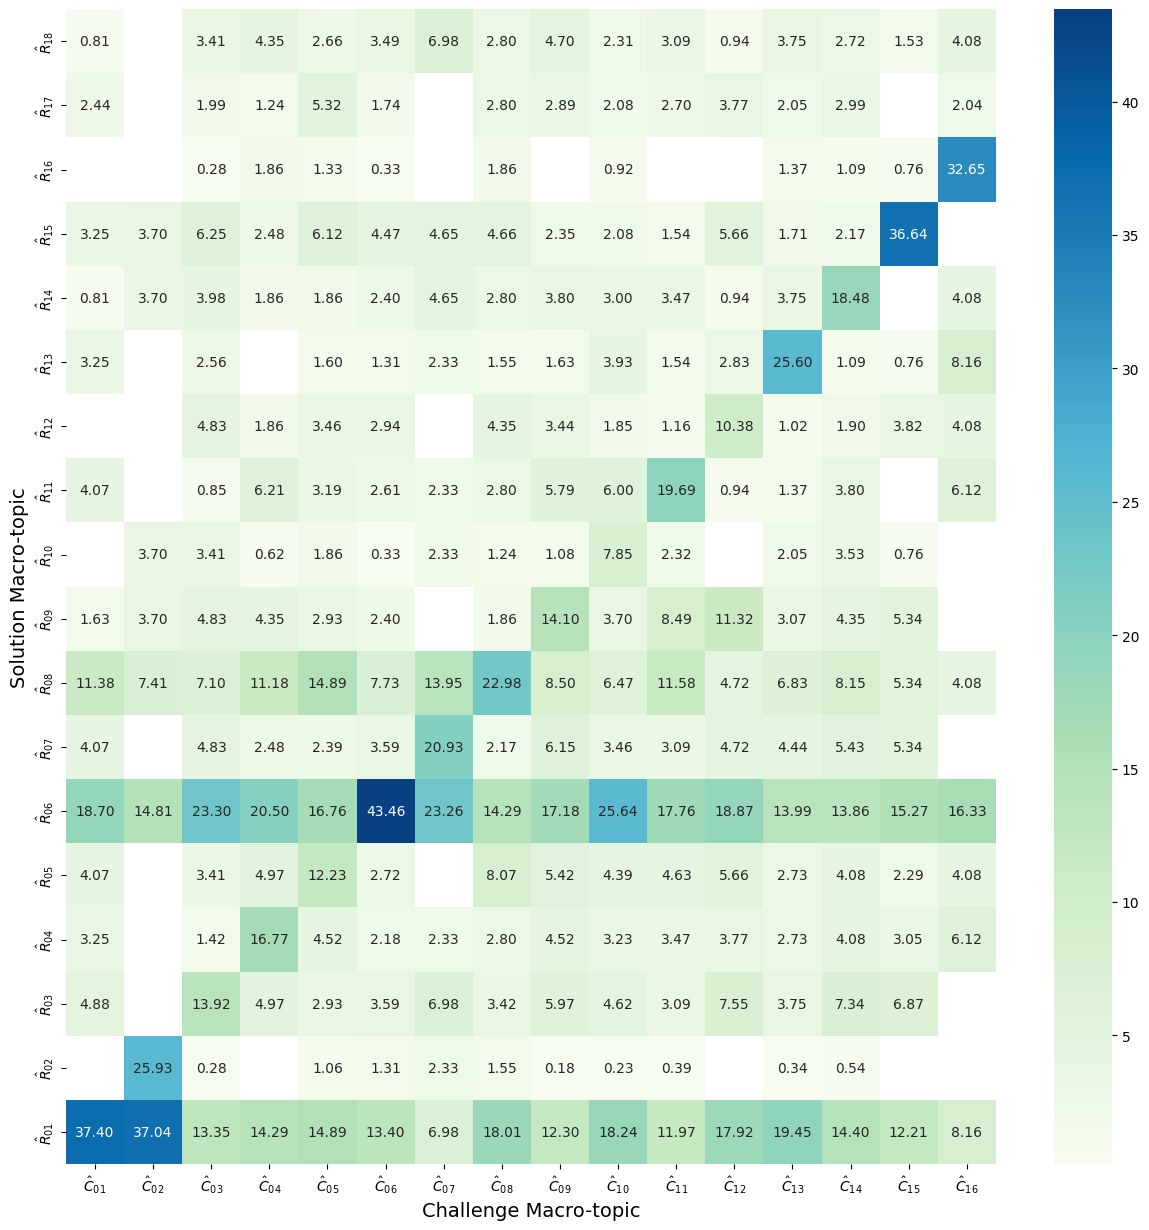

In [15]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))
df = df[df['Solution_summary_topic_macro'] != -1]

df['Challenge_topic_macro'] = df['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
df['Solution_summary_topic_macro'] = df['Solution_summary_topic_macro'].apply(lambda x: r'$\hat{R}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{R}_{' + str(x+1) + '}$')

df_statistics = df[['Challenge_topic_macro', 'Solution_summary_topic_macro']].value_counts().reset_index(name='count')
df_grouped = df_statistics.groupby('Challenge_topic_macro')['count'].sum().reset_index()
df_grouped.rename(columns={'count': 'sum'}, inplace=True)
df_merged = pd.merge(df_statistics, df_grouped, on='Challenge_topic_macro')
df_merged['normalized_count'] = df_merged['count'] / df_merged['sum'] * 100

plt.figure(figsize=(15, 15))
df_heatmap = df_merged.pivot_table(values='normalized_count', index='Solution_summary_topic_macro', columns='Challenge_topic_macro', aggfunc=np.mean)
# Get the diagonal values
diagonal_values = np.diag(df_heatmap)
# Check the number of values that are at least 25
count_above_25 = sum(diagonal_values >= 25)
print(count_above_25)
ax = sns.heatmap(df_heatmap, cmap="GnBu", annot=True, fmt=".2f")
ax.invert_yaxis()
ax.set_xlabel('Challenge Macro-topic', fontsize=14)
ax.set_ylabel('Solution Macro-topic', fontsize=14)
plt.savefig(os.path.join(path_rq4, f'Solution_heatmap_macro.pdf'), bbox_inches='tight')
plt.show()

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_68387/3536794835.py:15: FutureWarning:

The provided callable <function mean at 0x10846f640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



8


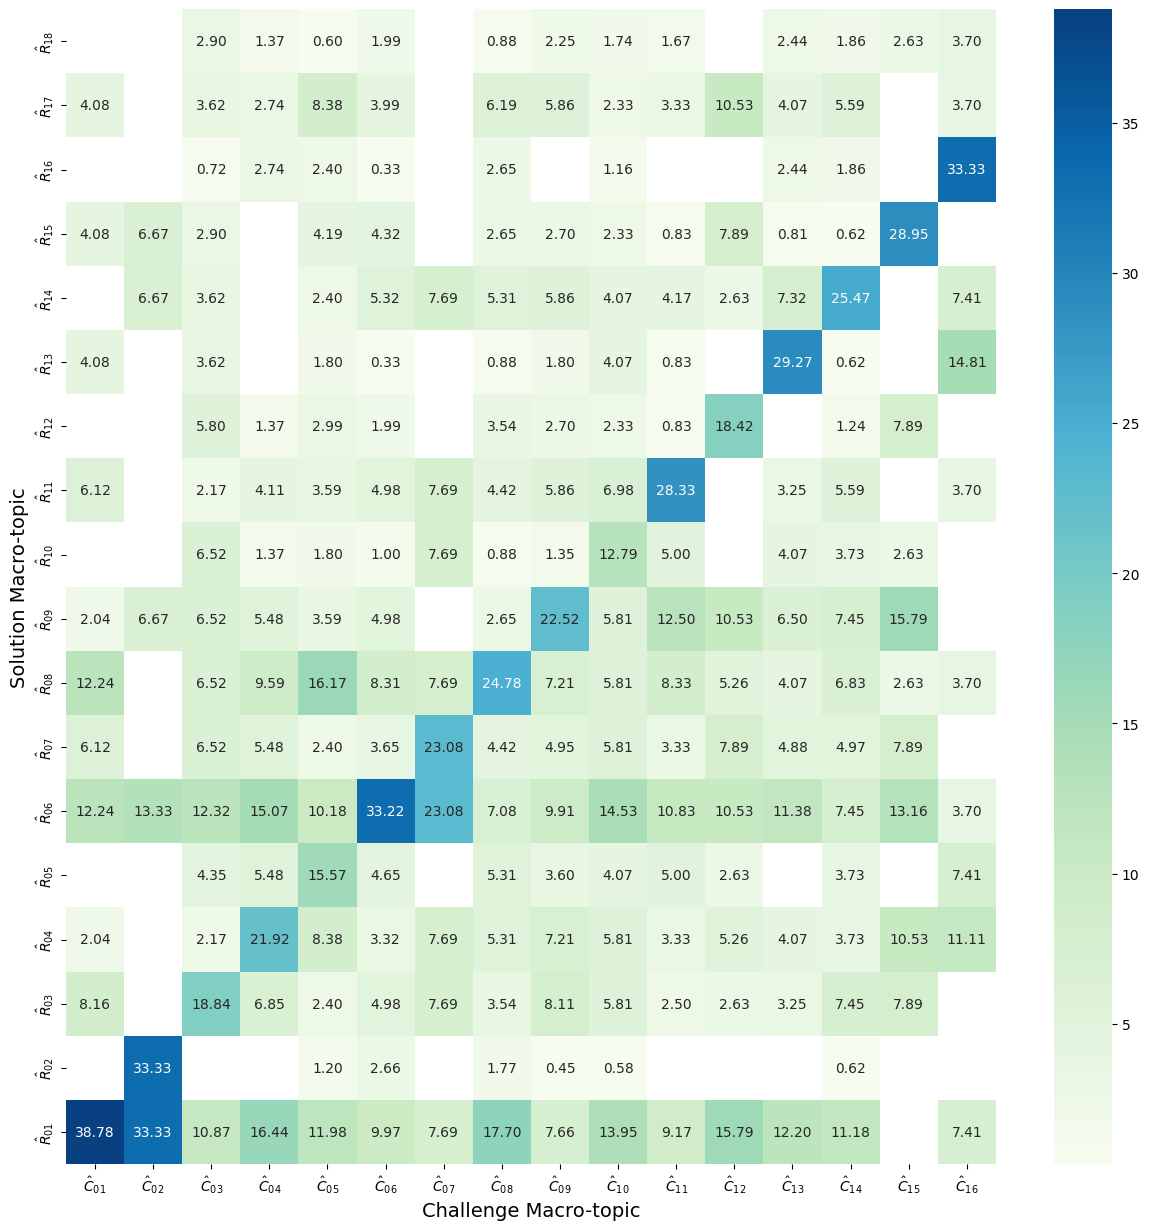

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_68387/3536794835.py:15: FutureWarning:

The provided callable <function mean at 0x10846f640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



4


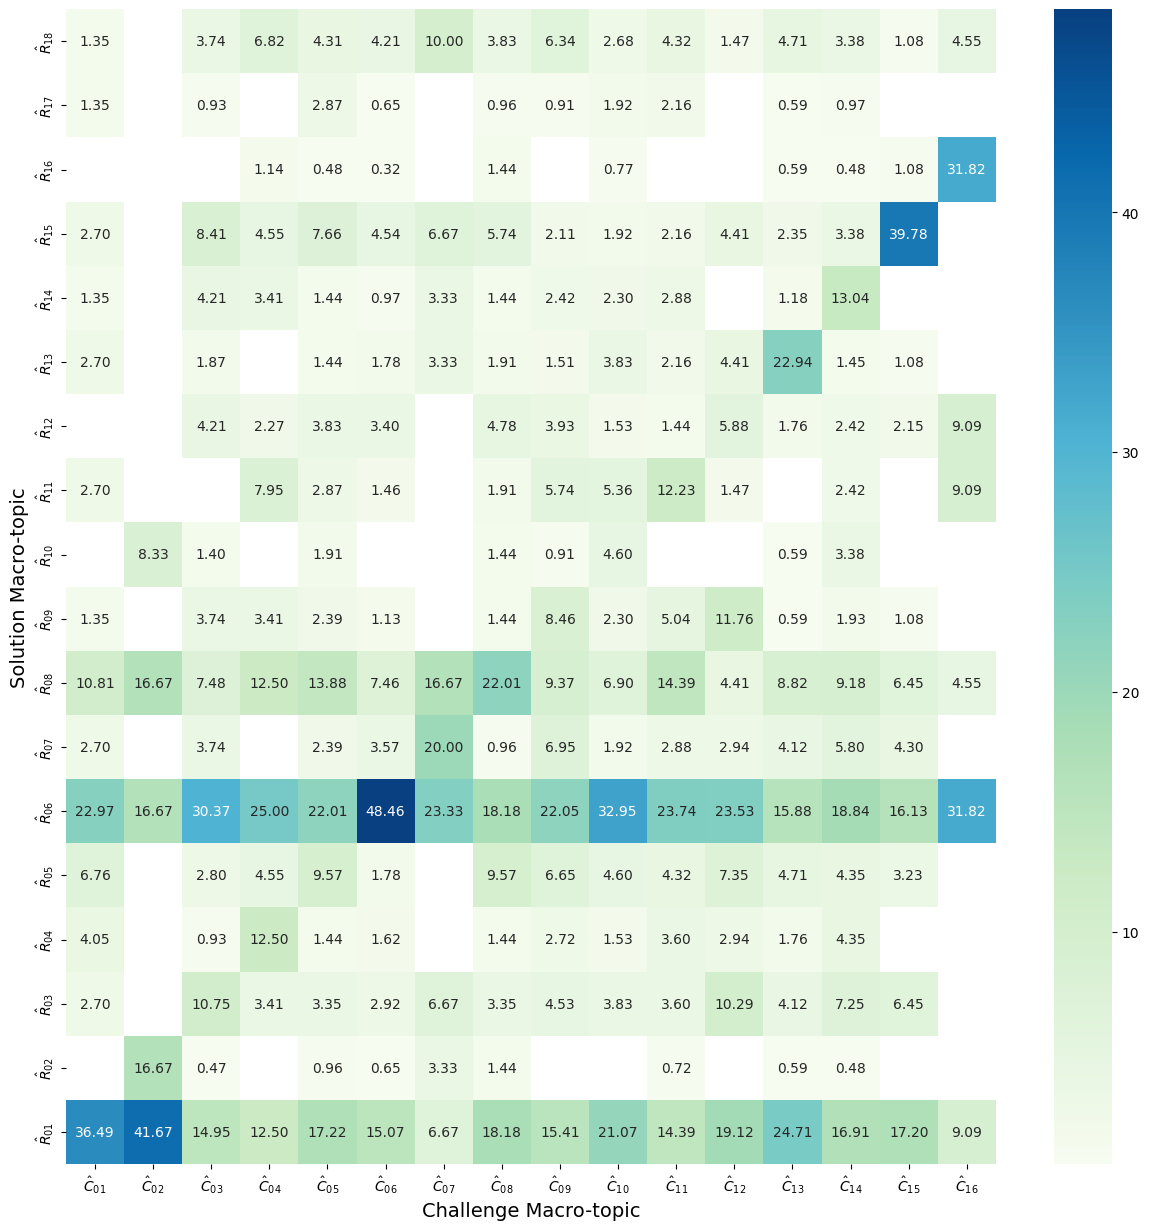

In [16]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))
df = df[df['Solution_summary_topic_macro'] != -1]

for type, group in df.groupby('Challenge_type'):
    group['Challenge_topic_macro'] = group['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
    group['Solution_summary_topic_macro'] = group['Solution_summary_topic_macro'].apply(lambda x: r'$\hat{R}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{R}_{' + str(x+1) + '}$')

    df_statistics = group[['Challenge_topic_macro', 'Solution_summary_topic_macro']].value_counts().reset_index(name='count')
    df_grouped = df_statistics.groupby('Challenge_topic_macro')['count'].sum().reset_index()
    df_grouped.rename(columns={'count': 'sum'}, inplace=True)
    df_merged = pd.merge(df_statistics, df_grouped, on='Challenge_topic_macro')
    df_merged['normalized_count'] = df_merged['count'] / df_merged['sum'] * 100

    plt.figure(figsize=(15, 15))
    df_heatmap = df_merged.pivot_table(values='normalized_count', index='Solution_summary_topic_macro', columns='Challenge_topic_macro', aggfunc=np.mean)
    # Get the diagonal values
    diagonal_values = np.diag(df_heatmap)
    # Check the number of values that are at least 25
    count_above_25 = sum(diagonal_values >= 25)
    print(count_above_25)
    ax = sns.heatmap(df_heatmap, cmap="GnBu", annot=True, fmt=".2f")
    ax.invert_yaxis()
    ax.set_xlabel('Challenge Macro-topic', fontsize=14)
    ax.set_ylabel('Solution Macro-topic', fontsize=14)
    plt.savefig(os.path.join(path_rq4, f'{type.capitalize()} solution heatmap macro.pdf'), bbox_inches='tight')
    plt.show()

In [12]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))
df = df[df['Solution_summary_topic_macro'] != -1]
df_number = pd.DataFrame()

for index, df_topic in df.groupby('Solution_summary_topic_macro'):
    entry = {
        'Index': r'$\hat{R}_{0' + str(index + 1) + '}$' if index < 9 else r'$\hat{R}_{' + str(index + 1) + '}$',
        'Macro-topic': macro_topic_indexing[index],
    }
    for name, group in df_topic.groupby('Challenge_type'):
        entry[f'Prevalence (%) [{name}]'] = round(len(group)/len(df[df['Challenge_type'] == name])*100, 2)
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

# df_number.sort_values(by=['Prevalence (%) [problem]'], ascending=False, inplace=True)
print(df_number.to_latex(float_format="%.2f", index=False, escape=True))

\begin{tabular}{llrr}
\toprule
Index & Macro-topic & Prevalence (%) [knowledge] & Prevalence (%) [problem] \\
\midrule
$\hat{R}_{01}$ & Code Development & 12.15 & 17.42 \\
$\hat{R}_{02}$ & Code Management & 1.13 & 0.58 \\
$\hat{R}_{03}$ & Computation Management & 6.21 & 4.63 \\
$\hat{R}_{04}$ & Data Development & 5.71 & 2.33 \\
$\hat{R}_{05}$ & Data Management & 4.86 & 4.77 \\
$\hat{R}_{06}$ & Environment Management & 14.69 & 28.86 \\
$\hat{R}_{07}$ & Experiment Management & 4.75 & 3.72 \\
$\hat{R}_{08}$ & File Management & 8.98 & 10.06 \\
$\hat{R}_{09}$ & Model Deployment & 8.14 & 2.99 \\
$\hat{R}_{10}$ & Model Development & 3.45 & 1.24 \\
$\hat{R}_{11}$ & Model Management & 6.16 & 3.13 \\
$\hat{R}_{12}$ & Network Management & 2.66 & 3.10 \\
$\hat{R}_{13}$ & Observability Management & 3.67 & 3.24 \\
$\hat{R}_{14}$ & Pipeline Management & 6.27 & 2.66 \\
$\hat{R}_{15}$ & Security Management & 3.22 & 5.39 \\
$\hat{R}_{16}$ & User Interface Management & 1.58 & 0.69 \\
$\hat{R}_{17}$ & Com

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_13141/2673350221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Challenge_topic_macro'] = group['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_13141/2673350221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Solution_summary_topic'] = group['Solution_summary_topic'].apply(lambda x: r'$R_{0' + str

knowledge


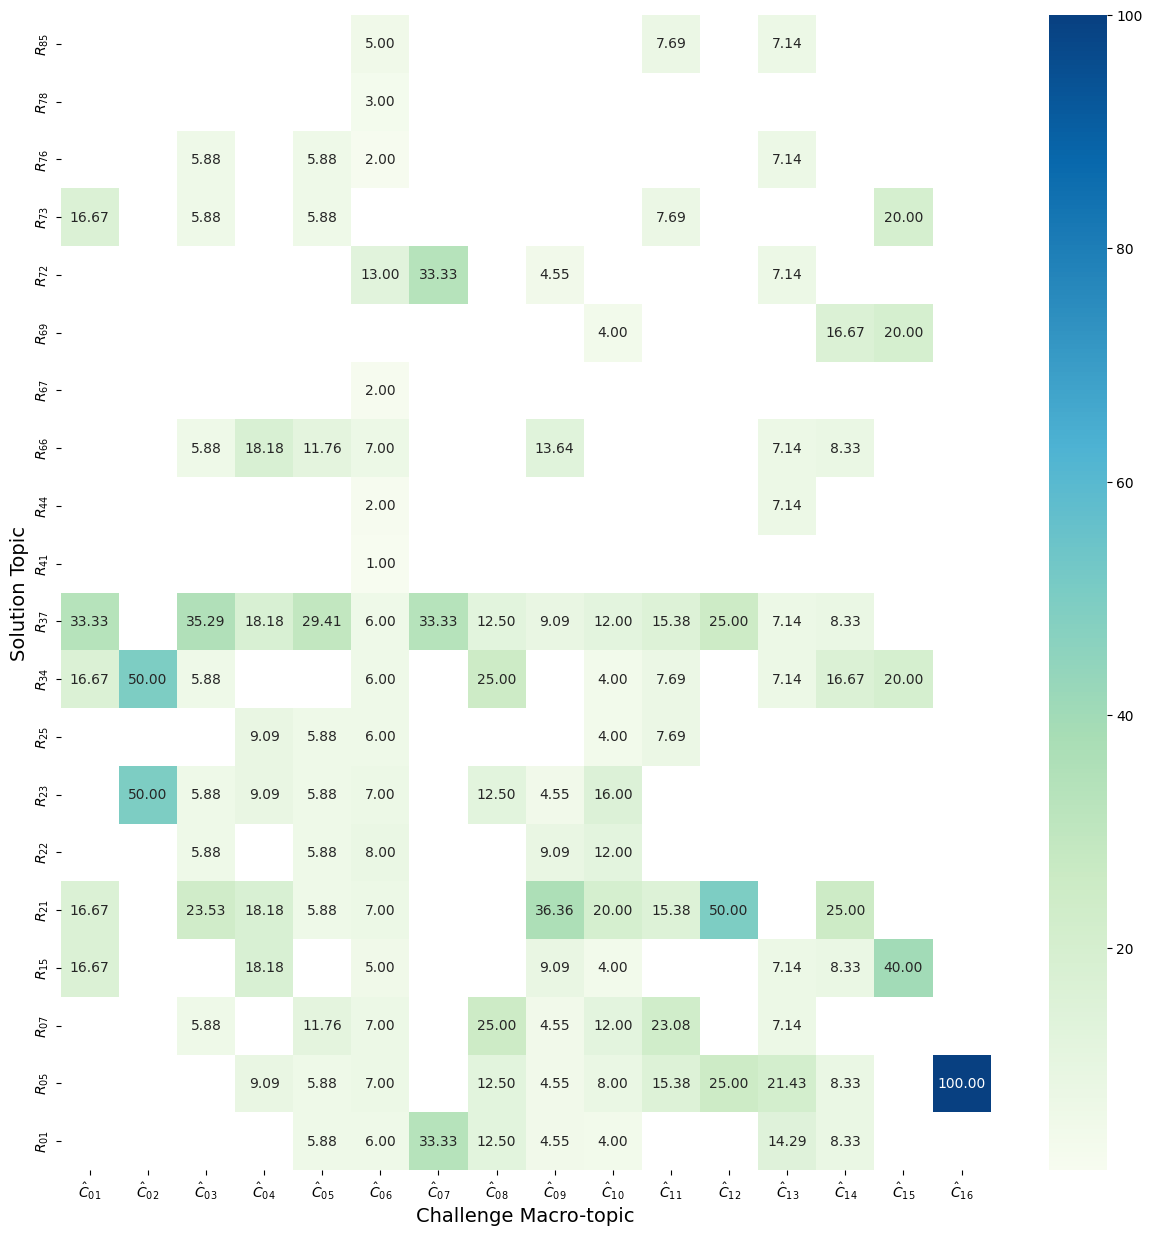

/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_13141/2673350221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Challenge_topic_macro'] = group['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
/var/folders/p7/fg_w39cx6pq23vf3798tdmq00000gn/T/ipykernel_13141/2673350221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['Solution_summary_topic'] = group['Solution_summary_topic'].apply(lambda x: r'$R_{0' + str

problem


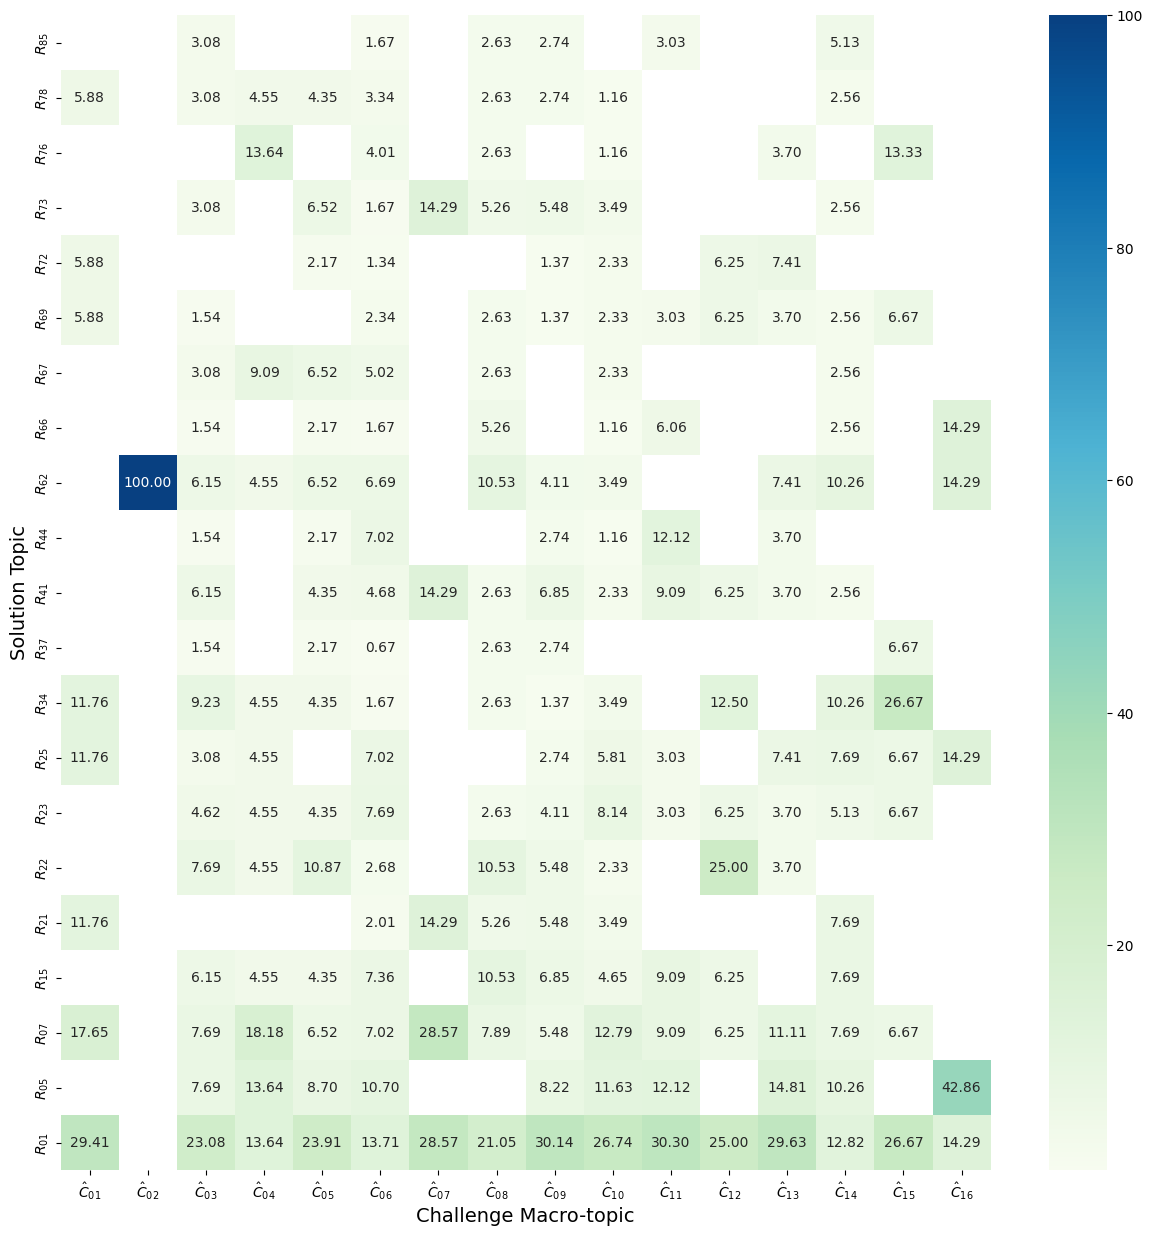

In [13]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))

for type, group in df.groupby('Challenge_type'):
    group = group[group['Solution_summary_topic_macro'] == zoom_mapping[type]]
    group['Challenge_topic_macro'] = group['Challenge_topic_macro'].apply(lambda x: r'$\hat{C}_{0' + str(x+1) + '}$' if x < 9 else r'$\hat{C}_{' + str(x+1) + '}$')
    group['Solution_summary_topic'] = group['Solution_summary_topic'].apply(lambda x: r'$R_{0' + str(x+1) + '}$' if x < 9 else r'$R_{' + str(x+1) + '}$')

    df_statistics = group[['Challenge_topic_macro', 'Solution_summary_topic']].value_counts().reset_index(name='count')
    df_grouped = df_statistics.groupby('Challenge_topic_macro')['count'].sum().reset_index()
    df_grouped.rename(columns={'count': 'sum'}, inplace=True)
    df_merged = pd.merge(df_statistics, df_grouped, on='Challenge_topic_macro')
    df_merged['normalized_count'] = df_merged['count'] / df_merged['sum'] * 100

    plt.figure(figsize=(15, 15))
    df_heatmap = df_merged.pivot_table(values='normalized_count', index='Solution_summary_topic', columns='Challenge_topic_macro', aggfunc=np.mean)
    ax = sns.heatmap(df_heatmap, cmap="GnBu", annot=True, fmt=".2f")
    ax.invert_yaxis()
    ax.set_xlabel('Challenge Macro-topic', fontsize=14)
    ax.set_ylabel('Solution Topic', fontsize=14)
    plt.savefig(os.path.join(path_rq4, f'{type.capitalize()} solution heatmap.pdf'), bbox_inches='tight')
    print(type)
    plt.show()

In [14]:
df = pd.read_json(os.path.join(path_rq4, 'macro-topics.json'))

for type, df_type in df.groupby('Challenge_type'):
    df_type = df_type[df_type['Solution_summary_topic_macro'] == zoom_mapping[type]]
    df_number = pd.DataFrame()
    for index, group in df_type.groupby('Solution_summary_topic'):
        entry = {
            'Index': r'$R_{0' + str(index + 1) + '}$' if index < 9 else r'$R_{' + str(index + 1) + '}$',
            'Topic': topic_mapping[index],
            'Prevalence (%)': round(len(group)/len(df_type)*100, 2)
        }
        df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

    df_number.sort_values(by=['Prevalence (%)'], ascending=False, inplace=True)
    print(type)
    print(df_number.to_latex(float_format="%.2f", index=False, escape=True))

knowledge
\begin{tabular}{llr}
\toprule
Index & Topic & Prevalence (%) \\
\midrule
$R_{21}$ & Container Customization & 13.46 \\
$R_{37}$ & SDK Usage & 12.69 \\
$R_{05}$ & Package Installation & 8.08 \\
$R_{07}$ & Package Version & 7.69 \\
$R_{66}$ & Notebook Usage & 6.54 \\
$R_{23}$ & Package Addition & 6.54 \\
$R_{34}$ & Environment Variable & 6.54 \\
$R_{72}$ & Workspace Creation & 6.15 \\
$R_{15}$ & SDK Upgrade & 5.77 \\
$R_{22}$ & Docker & 5.77 \\
$R_{01}$ & Package Upgrade & 5.38 \\
$R_{25}$ & Environment Creation & 3.85 \\
$R_{85}$ & Notebook Instance & 2.69 \\
$R_{73}$ & Region Support & 1.92 \\
$R_{76}$ & Kernel Restart & 1.92 \\
$R_{69}$ & Package Import & 1.54 \\
$R_{44}$ & Package Reinstallation & 1.15 \\
$R_{78}$ & Docker Update & 1.15 \\
$R_{67}$ & Python Version & 0.77 \\
$R_{41}$ & Package Downgrade & 0.38 \\
\bottomrule
\end{tabular}

problem
\begin{tabular}{llr}
\toprule
Index & Topic & Prevalence (%) \\
\midrule
$R_{01}$ & Package Upgrade & 20.45 \\
$R_{05}$ & Packag